In [1]:
import sqlite3
import pandas as pd
import re
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import emoji
from transformers import BertTokenizer
conn = sqlite3.connect("flipkart_products.db")

In [2]:
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn)["name"].tolist()
tables

['items',
 'ECMB000001',
 'ECMB000002',
 'ECMB000003',
 'ECMB000004',
 'ECMB000005',
 'ECMB000006',
 'ECMB000007',
 'ECMB000008',
 'ECMB000009',
 'ECMB000010',
 'ECMB000011',
 'ECMB000012',
 'ECMB000013',
 'ECMB000014',
 'ECMB000015',
 'ECMB000016',
 'ECMB000017',
 'ECMB000018',
 'ECMB000019',
 'ECMB000020',
 'ECMB000021',
 'ECMB000022',
 'ECMB000023',
 'ECMB000024',
 'ECMB000025',
 'ECMB000026',
 'ECMB000027',
 'ECMB000028',
 'ECMB000029',
 'ECMB000030',
 'ECMB000031',
 'ECMB000032',
 'ECMB000033',
 'ECMB000034',
 'ECMB000035',
 'ECMB000036',
 'ECMB000037',
 'ECMB000038',
 'ECMB000039',
 'ECMB000040',
 'ECMB000041',
 'ECMB000042',
 'ECMB000043',
 'ECMB000044',
 'ECMB000045',
 'ECMB000046',
 'ECMB000047',
 'ECMB000048',
 'ECMB000049',
 'ECMB000050',
 'ECMB000051',
 'ECMB000052',
 'ECMB000053',
 'ECMB000054',
 'ECMB000055',
 'ECMB000056',
 'ECMB000057',
 'ECMB000058',
 'ECMB000059',
 'ECMB000060',
 'ECMB000061',
 'ECMB000062',
 'ECMB000063',
 'ECMB000064',
 'ECMB000065',
 'ECMB000066',


In [3]:
con = sqlite3.connect("flipkart_products.db")
items = pd.read_sql_query("SELECT * from items", con)
con.close()

In [4]:
con = sqlite3.connect("flipkart_products.db")

# collect review tables
review_dfs = []
for i in range(1, len(items) + 1):  # starts at 1
    table_name = f"ECMB{i:06d}"
    df_temp = pd.read_sql_query(f"SELECT * from {table_name}", con)
    review_dfs.append(df_temp)

# combine all reviews into one DataFrame
df = pd.concat(review_dfs, ignore_index=True)

con.close()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53493 entries, 0 to 53492
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  53493 non-null  object
 1   review_id   53493 non-null  object
 2   title       53493 non-null  object
 3   review      53493 non-null  object
 4   likes       53493 non-null  object
 5   dislikes    53493 non-null  object
 6   ratings     48488 non-null  object
 7   reviewer    53493 non-null  object
dtypes: object(8)
memory usage: 3.3+ MB


In [6]:
df.sample(10)

,product_id,review_id,title,review,likes,dislikes,ratings,reviewer
17268,ECMB000012,ECMB0000120000285,Must buy!,Good mobile,0,0,5,Flipkart Customer
46264,ECMB000057,ECMB0000570000009,Worth every penny,one of the best phones you can buy.i am a loya...,139,33,5,joydeep majumder
2679,ECMB000005,ECMB0000050000042,Great product,Very Good 👍,7,4,5,Sami Ahamad
26896,ECMB000028,ECMB0000280000806,Terrific,Mobile used and performance is good.MI produce...,0,0,5,Santosh RANE
37364,ECMB000045,ECMB0000450000425,Worth the money,All things are exact as I required,0,0,4,Josmendra Tanti
9297,ECMB000010,ECMB0000100003455,Brilliant,Very nice,0,0,5,Dinesh Kumar Sharma
45886,ECMB000055,ECMB0000550000890,Just wow!,Good product in this price,1,0,5,Mohammad Irshad
22990,ECMB000024,ECMB0000240000005,Must buy!,Very nice and awesome mobile worth for money.....,323,76,5,Hari Prasath1291
22886,ECMB000023,ECMB0000230001541,Great product,"some times screen touch is not working,some ti...",1,0,5,ravi teja
35038,ECMB000042,ECMB0000420000150,Best in the market!,You can Play PUBG in it on medium graphics wit...,11,1,5,Flipkart Customer


## Preprocessing
### Data Cleaning

<Figure size 2500x2000 with 0 Axes>

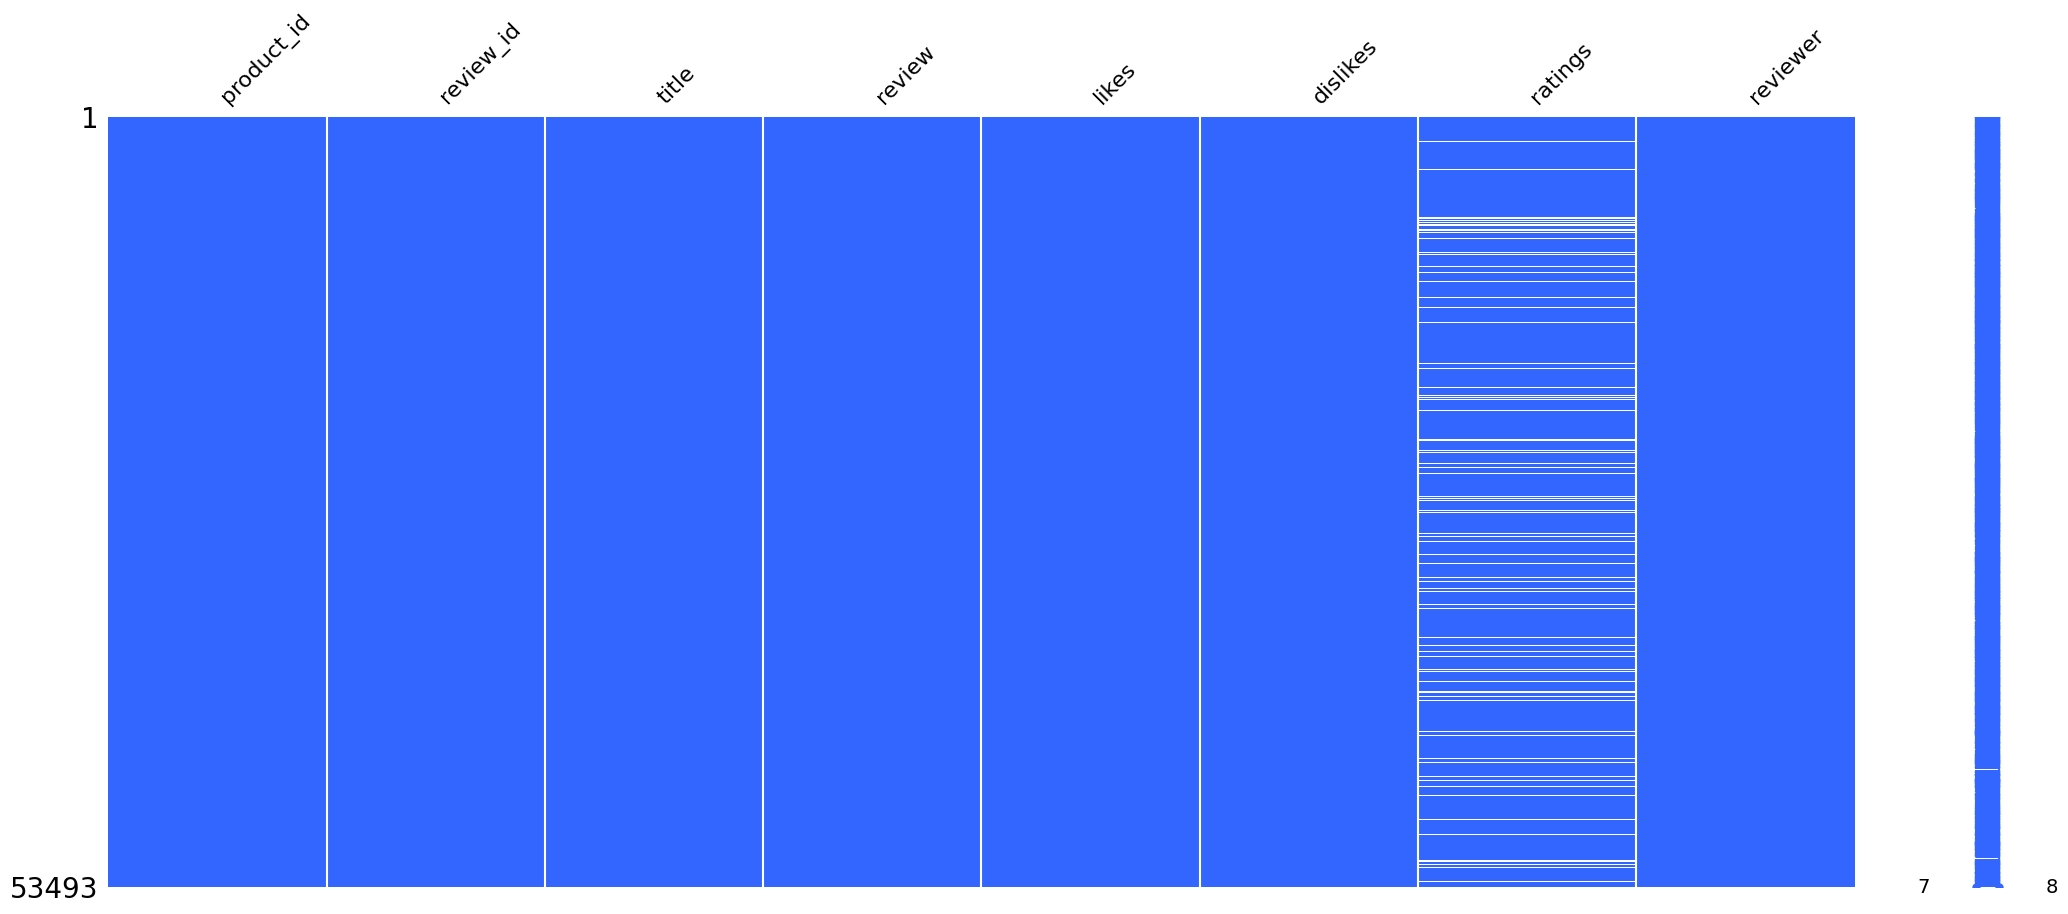

In [7]:
import missingno as msno
plt.figure(figsize=(25, 20))
msno.matrix(df, color=[0.2, 0.4, 1])
plt.show()

In [8]:
df.dropna(inplace=True, axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48488 entries, 0 to 53490
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  48488 non-null  object
 1   review_id   48488 non-null  object
 2   title       48488 non-null  object
 3   review      48488 non-null  object
 4   likes       48488 non-null  object
 5   dislikes    48488 non-null  object
 6   ratings     48488 non-null  object
 7   reviewer    48488 non-null  object
dtypes: object(8)
memory usage: 3.3+ MB


<Figure size 2500x2000 with 0 Axes>

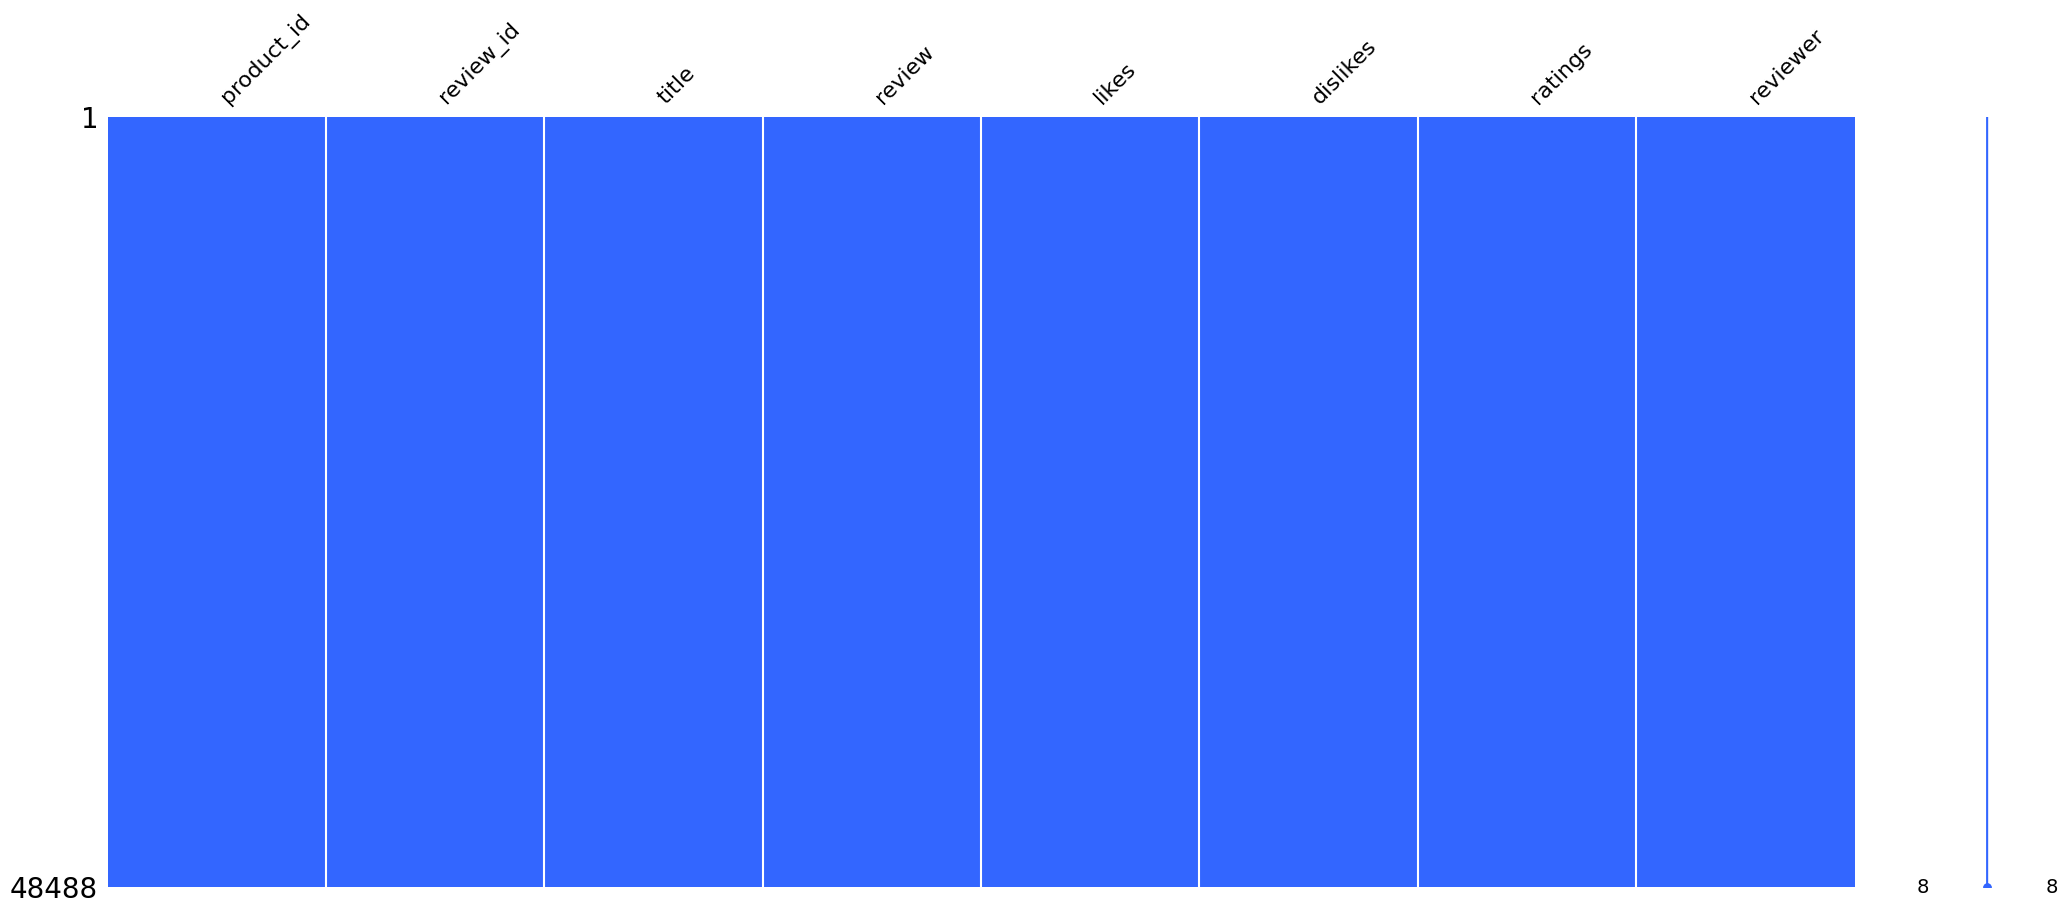

In [9]:
plt.figure(figsize=(25, 20))
msno.matrix(df, color=[0.2, 0.4, 1])
plt.show()

In [10]:
def clean_for_bert(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # only if using 'bert-base-uncased'
    text = re.sub(r"http\S+|www\S+", "", text)   # remove urls
    text = emoji.replace_emoji(text, replace="") # remove emojis
    return text

df = df[['review', 'ratings']].dropna()
df['review'] = df['review'].apply(clean_for_bert)

df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce')

# Drop rows where rating could not be converted (NaN)
df = df.dropna(subset=['ratings'])

# Create sentiment labels from ratings
def rating_to_label(r):
    
    if r >= 4:
        return 2   # positive
    elif r == 3:
        return 1   # neutral
    else:
        return 0   # negative

df['label'] = df['ratings'].apply(rating_to_label)

### Language Detection and Translation

import re
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate

def fast_transliterate(text):
    if not isinstance(text, str):
        return ""
    
    # If Hindi script (Devanagari), transliterate to Roman
    if re.search(r'[\u0900-\u097F]', text):
        try:
            text = transliterate(text, sanscript.DEVANAGARI, sanscript.ITRANS)
        except:
            pass
    return text

# Apply to all 50k reviews
df['review_translit'] = df['review'].apply(fast_transliterate)

# Quick check
print(df[['review', 'review_translit']].sample(10))


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48488 entries, 0 to 53490
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   review   48488 non-null  object
 1   ratings  48488 non-null  int64 
 2   label    48488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [12]:
df.sample(10)

,review,ratings,label
41546,superb very nice product,5,2
38399,this is a phone which is not only a phone its ...,5,2
3612,nice product according to its budget. but it's...,5,2
27515,good one,5,2
21810,mobile is good but the camera is only 12 mp so...,4,2
35427,awesome camera is so good,5,2
46625,"it's gud quality smartphone in bugdet, camera ...",4,2
34073,value for money,5,2
21143,very nice phone i am also happy.,5,2
13760,mobile is good....but phonr pickup any time so...,4,2


In [13]:
df = df[['review', 'label', 'ratings']]

In [14]:
df.head()

,review,label,ratings
0,wow superb i love it battery backup so nice,2,5
1,mobile so good in range redmi 9a has miui 12 l...,2,4
2,wonderful device and smart phone best camera b...,2,5
3,very good mobile. value for money. battery bac...,2,5
4,really great.... value for money...,2,5


In [15]:
df.label.value_counts()

label
2    44751
1     3737
Name: count, dtype: int64

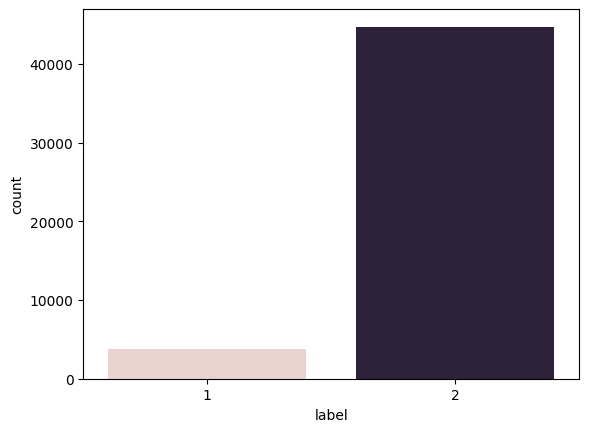

In [16]:
import seaborn as sns
sns.countplot(x = "label", data = df, hue = 'label', legend = False)
plt.show()

In [17]:
from imblearn.over_sampling import RandomOverSampler

X = df['review'].values.reshape(-1,1)   # reviews as input
y = df['label']                         # 0=negative, 1=positive

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

# Back into DataFrame
df_balanced = pd.DataFrame({
    "review": X_res.flatten(),
    "label": y_res
})

print(df_balanced['label'].value_counts())

label
2    44751
1    44751
Name: count, dtype: int64


In [18]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_balanced['review'].tolist(),
    df_balanced['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_balanced['label']
)

In [19]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

In [20]:
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import BertTokenizerFast

# Use the Fast tokenizer (much faster)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Example
texts = df['review'].tolist()
labels = df['label'].tolist()

encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Custom Dataset
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Split train/val
from sklearn.model_selection import train_test_split
train_indices, val_indices = train_test_split(range(len(labels)), test_size=0.2, random_state=42, stratify=labels)

train_encodings = {k: v[train_indices] for k,v in encodings.items()}
val_encodings   = {k: v[val_indices] for k,v in encodings.items()}

train_labels = [labels[i] for i in train_indices]
val_labels   = [labels[i] for i in val_indices]

train_dataset = ReviewDataset(train_encodings, train_labels)
val_dataset   = ReviewDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16)

# Quick check
for batch in train_loader:
    print(batch['input_ids'].shape, batch['labels'].shape)
    break

torch.Size([16, 128]) torch.Size([16])


In [ ]:
import torch
from torch.optim import AdamW
from tqdm import tqdm

from transformers import DistilBertForSequenceClassification

# 3-class problem (negative, neutral, positive)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optim = AdamW(model.parameters(), lr=5e-5)

# Number of epochs
epochs = 3

for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch in loop:
        optim.zero_grad()
        
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        # Backward pass
        loss.backward()
        optim.step()
        
        # Display loss in progress bar
        loop.set_postfix(loss=loss.item())
    
    # Optional: evaluate after each epoch
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    from sklearn.metrics import classification_report
    print(f"\nClassification Report after epoch {epoch+1}:")
    print(classification_report(all_labels, all_preds, target_names=["Negative","Neutral","Positive"]))
    
    model.train()  # switch back to training mode for next epoch

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

C:\Users\admin\anaconda03\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\admin\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|                                                          | 2/2425 [00:20<6:57:16, 10.33s/it, loss=0.974]

In [ ]:
from sklearn.metrics import classification_report

model.eval()
preds, true_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, preds, target_names=["Negative","Positive"]))